In [1]:
# Add current directory to Python path
import sys, os
sys.path.insert(0, os.getcwd())

# Import necessary libraries
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import nibabel as nib
from nibabel import cifti2
import pickle

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Global parameters
data_dir = '/home/users/dmandla1/BRAIN_STATE_PREDICTION/HCP_S1200_GroupAvg_v1/'  # ensure trailing slash
window_size = 30             # input sequence length
max_window_size = 50         # for dataset indexing
input_size = 379             # number of brain regions per timepoint
num_predicted_features = 379
batch_first = True

# Model hyperparameters
dim_val = 760                # transformer model dimension (divisible by n_heads)
n_heads = 8
n_encoder_layers = 4
n_decoder_layers = 4
dec_seq_len = 1              # decoder input length (1 timepoint)
output_sequence_length = 1

# Training parameters
epochs = 50                  # Increase epochs for improvement
lr = 1e-4
batch_size = 512

# Improvement options:
clip_value = 1.0             # gradient clipping value
patience = 5                 # early stopping patience


Device: cuda


In [2]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /home/users/dmandla1/Brain_State_Prediction


In [3]:
import os
import glob
import numpy as np
import nibabel as nib
from nibabel import cifti2
from torch.utils.data import DataLoader
from fmri_dataset import rfMRIDataset  # ensure fmri_dataset.py is in your working directory

# Set the data directory (update the path if needed) and ensure it ends with a trailing slash.
data_dir = '/home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/'
if not data_dir.endswith('/'):
    data_dir += '/'

# Check that the directory exists.
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The data directory does not exist: {data_dir}. Please verify the path.")

all_items = sorted(os.listdir(data_dir))
print("Contents of data_dir:", all_items)

# Find all files ending with .nii or .nii.gz in the data directory.
nii_files = glob.glob(os.path.join(data_dir, "*.nii*"))
print("Found nii files:", nii_files)

# Process each nii file into a simulated time series (shape: 1200 x 379)
subject_list = []
for f in nii_files:
    try:
        # Load the file using nibabel.
        img = nib.load(f)
        data_arr = img.get_fdata().squeeze()
        print(f"Loaded {f} with shape {data_arr.shape}")
        
        # Flatten the data and take the first 379 elements.
        data_vec = np.asarray(data_arr).flatten()
        if data_vec.size < 379:
            print(f"File {f} has less than 379 elements, skipping.")
            continue
        data_vec = data_vec[:379]
        print(f"Reduced data from {f} to shape: {data_vec.shape}")
        
        # Simulate a time series: replicate the vector for 1200 timepoints and add slight noise.
        n_timepoints = 1200
        ts = np.tile(data_vec, (n_timepoints, 1))
        ts += 0.01 * np.random.randn(n_timepoints, 379)
        
        # Create a subject ID from the filename.
        base = os.path.basename(f)
        if base.endswith('.nii.gz'):
            subject_id = base[:-7]
        else:
            subject_id = os.path.splitext(base)[0]
        
        # Create a subject folder in the data directory.
        subj_dir = os.path.join(data_dir, subject_id)
        if not os.path.exists(subj_dir):
            os.makedirs(subj_dir)
            print(f"Created subject folder: {subj_dir}")
        
        # Save the simulated time series as a .npy file using the expected naming pattern.
        out_file = os.path.join(subj_dir, subject_id + "_REST_p.npy")
        np.save(out_file, ts)
        subject_list.append(subject_id)
        print(f"Processed file {f} into subject {subject_id}.")
    except Exception as e:
        print(f"Error processing {f}: {e}")

print("Subjects processed:", subject_list)
if len(subject_list) == 0:
    raise ValueError("No subjects were processed from the .nii files!")

# For simplicity, we use all processed subjects for both training and testing.
train_sub = subject_list
test_sub = subject_list
print("Train subjects:", train_sub)
print("Test subjects:", test_sub)

# Create dataset objects.
# Note: rfMRIDataset's __init__ expects (data_dir, sub_list, sample_size, max_window_size).
# Here, sample_size is the number of input timepoints (set to 30) and max_window_size is 50.
train_dataset = rfMRIDataset(data_dir, train_sub, 30, 50)
test_dataset  = rfMRIDataset(data_dir, test_sub, 30, 50)
print("Number of samples in train_dataset:", len(train_dataset))
print("Number of samples in test_dataset:", len(test_dataset))

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
print("DataLoaders created successfully.")


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Contents of data_dir: ['.DS_Store', 'ConnectomeWorkbenchTutorial_HCP_S1200_GroupAvg_v1.pdf', 'Gordon333.32k_fs_LR.dlabel', 'Gordon333.32k_fs_LR.dlabel.nii', 'Gordon333_Key.txt', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar.nii', 'HCP_S1200_GroupAvg_v1.scene', 'Human.Brodmann09.32k_fs_LR.dlabel', 'Human.Brodmann09.32k_fs_LR.dlabel.nii', 'Human.Composite_VDG11.32k_fs_LR.dlabel', 'Human.Composite_VDG11.32k_fs_LR.dlabel.nii', 'Human.MedialWall_Conte69.32k_fs_LR.d

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii with shape (59412,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii into subject Q1-Q6_RelatedValidation210.CorticalAreas_dil_Fina

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.curvature_MSMAll.32k_fs_LR.dscalar.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.nii with shape (86, 91282)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.nii into subject HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.ni

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.thickness_MSMAll.32k_fs_LR.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.curvature_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.curvature_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.curvature_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.curvature_MSMAll.32k_fs_LR.dscalar.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.sulc_MSMAll.32k_fs_LR.dscalar.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT1wDividedByT2w.nii.gz with shape (260, 311, 260)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT1wDividedByT2w.nii.gz to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT1wDividedByT2w.nii.gz into subject S1200_AverageT1wDividedByT2w.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.nii with shape (86, 91282)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.nii into subject HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.
Error processing /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/RSN-networks.32k_fs_LR.dlabel.nii: Only CIFTI-2 files are supported; found version 1


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.thickness_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.thickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.thickness_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.thickness_MSMAll.32k_fs_LR.dscalar.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.midthickness_MSMAll_va.32k_fs_LR.dscalar.nii with shape (1096, 59412)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.midthickness_MSMAll_va.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.midthickness_MSMAll_va.32k_fs_LR.dscalar.nii into subject S1200.All.midthickness_MSMAll_va.32k_fs_LR.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT2w_restore.nii.gz with shape (260, 311, 260)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT2w_restore.nii.gz to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT2w_restore.nii.gz into subject S1200_AverageT2w_restore.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.sulc_MSMAll.32k_fs_LR.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT1w_restore.nii.gz with shape (260, 311, 260)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT1w_restore.nii.gz to shape: (379,)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200_AverageT1w_restore.nii.gz into subject S1200_AverageT1w_restore.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Human.Composite_VDG11.32k_fs_LR.dlabel.nii with shape (64984,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Human.Composite_VDG11.32k_fs_LR.dlabel.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Human.Composite_VDG11.32k_fs_LR.dlabel.nii into subject Human.Composite_VDG11.32k_fs_LR.dlabel.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii with shape (64984,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii into subject Human.MedialWall_Conte69.32k_fs_LR.dlabel.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/H

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii with shape (91282,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/Gordon333.32k_fs_LR.dlabel.nii into subject Gordon333.32k_fs_LR.dlabel.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.corrThickness_MSMAll.32k_fs_LR.dscalar.nii with shape (1096, 59412)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.corrThickness_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.All.corrThickness_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.All.corrThickness_MSMAll.32k_fs_LR.dscalar.
Loaded /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii with shape (59412,)
Reduced data from /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii to shape: (379,)
Processed file /home/users/dmandla1/Brain_State_Prediction/HCP_S1200_GroupAvg_v1/S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii into subject S1200.SmoothedMyelinMap_BC_MSMAll.32k_fs_LR.dscalar.
Subjects processed: ['Human.Brodmann09.32k_fs_LR.dlabel', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar', 'S1200.All

In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# A helper module to trim extra padding (from TCN implementation)
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
         super(Chomp1d, self).__init__()
         self.chomp_size = chomp_size
    def forward(self, x):
         return x[:, :, :-self.chomp_size].contiguous()

# TemporalBlock: one residual block with two convolutional layers.
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
         super(TemporalBlock, self).__init__()
         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                                stride=stride, padding=padding, dilation=dilation)
         self.chomp1 = Chomp1d(padding)
         self.relu1 = nn.ReLU()
         self.dropout1 = nn.Dropout(dropout)
         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                                stride=stride, padding=padding, dilation=dilation)
         self.chomp2 = Chomp1d(padding)
         self.relu2 = nn.ReLU()
         self.dropout2 = nn.Dropout(dropout)
         self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                  self.conv2, self.chomp2, self.relu2, self.dropout2)
         self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
         self.relu = nn.ReLU()
    def forward(self, x):
         out = self.net(x)
         res = x if self.downsample is None else self.downsample(x)
         return self.relu(out + res)

# TemporalConvNet: stack multiple TemporalBlocks.
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
         super(TemporalConvNet, self).__init__()
         layers = []
         num_levels = len(num_channels)
         for i in range(num_levels):
              dilation_size = 2 ** i
              in_channels = num_inputs if i == 0 else num_channels[i-1]
              out_channels = num_channels[i]
              layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                       dilation=dilation_size, padding=(kernel_size-1)*dilation_size, dropout=dropout)]
         self.network = nn.Sequential(*layers)
    def forward(self, x):
         return self.network(x)

# TCN-based Model for brain state prediction.
# It takes an input sequence of shape (batch, window_size, input_size)
# and predicts the next timepoint (batch, input_size)
class TCNModel(nn.Module):
    def __init__(self, input_size, window_size, num_channels, dropout=0.2):
         super(TCNModel, self).__init__()
         # TCN expects input in (batch, channels, sequence_length)
         self.tcn = TemporalConvNet(num_inputs=input_size, num_channels=num_channels, kernel_size=3, dropout=dropout)
         # The TCN output shape is (batch, num_channels[-1], window_size)
         # We take the last time step and map to output size (input_size)
         self.fc = nn.Linear(num_channels[-1], input_size)
    def forward(self, x):
         # x: (batch, window_size, input_size) --> permute to (batch, input_size, window_size)
         x = x.permute(0, 2, 1)
         y = self.tcn(x)
         # take the last time step (i.e., index -1) from TCN output
         y = y[:, :, -1]
         # map to output
         out = self.fc(y)
         # reshape to (batch, 1, input_size)
         return out.unsqueeze(1)

# Example: define our TCN model with a channel configuration.
# You can adjust the num_channels list (e.g., [64, 64, 64]) as needed.
num_channels = [64, 64, 64]
model = TCNModel(input_size=input_size, window_size=window_size, num_channels=num_channels, dropout=0.2)
model.to(device)
model = model.double()
print(model)


TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(379, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(379, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(379, 64, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stri

Starting training for 10 epochs...


Epoch 1/50:   0%|          | 0/57 [00:00<?, ?it/s]

Validation: 100%|██████████| 28750/28750 [02:41<00:00, 178.01it/s]


Epoch 1: Train Loss=1.786944, Train R²=0.9993, Val Loss=1.570013, Val R²=0.9994


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 179.85it/s]


Epoch 2: Train Loss=1.470318, Train R²=0.9995, Val Loss=1.291557, Val R²=0.9995


Validation: 100%|██████████| 28750/28750 [02:41<00:00, 177.78it/s]


Epoch 3: Train Loss=1.146423, Train R²=0.9996, Val Loss=0.909449, Val R²=0.9997


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.80it/s]


Epoch 4: Train Loss=0.824609, Train R²=0.9997, Val Loss=0.619292, Val R²=0.9998


Validation: 100%|██████████| 28750/28750 [02:40<00:00, 178.62it/s]


Epoch 5: Train Loss=0.625705, Train R²=0.9998, Val Loss=0.449684, Val R²=0.9998


Validation: 100%|██████████| 28750/28750 [02:42<00:00, 177.31it/s]


Epoch 6: Train Loss=0.503242, Train R²=0.9998, Val Loss=0.363390, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.82it/s]


Epoch 7: Train Loss=0.428414, Train R²=0.9998, Val Loss=0.306481, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 180.33it/s]


Epoch 8: Train Loss=0.382471, Train R²=0.9999, Val Loss=0.276814, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:34<00:00, 185.98it/s]


Epoch 9: Train Loss=0.343804, Train R²=0.9999, Val Loss=0.249031, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:36<00:00, 183.98it/s]


Epoch 10: Train Loss=0.316271, Train R²=0.9999, Val Loss=0.234319, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:40<00:00, 179.22it/s]


Epoch 11: Train Loss=0.293714, Train R²=0.9999, Val Loss=0.216124, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 180.89it/s]


Epoch 12: Train Loss=0.273900, Train R²=0.9999, Val Loss=0.198310, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:35<00:00, 184.62it/s]


Epoch 13: Train Loss=0.255330, Train R²=0.9999, Val Loss=0.186233, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:34<00:00, 185.83it/s]


Epoch 14: Train Loss=0.241804, Train R²=0.9999, Val Loss=0.171488, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.45it/s]


Epoch 15: Train Loss=0.227382, Train R²=0.9999, Val Loss=0.159351, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 180.27it/s]


Epoch 16: Train Loss=0.212407, Train R²=0.9999, Val Loss=0.150917, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:40<00:00, 179.46it/s]


Epoch 17: Train Loss=0.203325, Train R²=0.9999, Val Loss=0.138571, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:37<00:00, 182.98it/s]


Epoch 18: Train Loss=0.187746, Train R²=0.9999, Val Loss=0.126895, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:35<00:00, 184.43it/s]


Epoch 19: Train Loss=0.176869, Train R²=0.9999, Val Loss=0.131271, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:34<00:00, 185.84it/s]


Epoch 20: Train Loss=0.168483, Train R²=0.9999, Val Loss=0.115906, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:45<00:00, 174.19it/s]


Epoch 21: Train Loss=0.159958, Train R²=0.9999, Val Loss=0.113422, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.81it/s]


Epoch 22: Train Loss=0.151976, Train R²=0.9999, Val Loss=0.104416, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.63it/s]


Epoch 23: Train Loss=0.151557, Train R²=0.9999, Val Loss=0.143620, Val R²=0.9999


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 179.96it/s]


Epoch 24: Train Loss=0.143693, Train R²=0.9999, Val Loss=0.094066, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.26it/s]


Epoch 25: Train Loss=0.132324, Train R²=1.0000, Val Loss=0.091756, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:40<00:00, 178.93it/s]


Epoch 26: Train Loss=0.125710, Train R²=1.0000, Val Loss=0.089358, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 179.91it/s]


Epoch 27: Train Loss=0.121295, Train R²=1.0000, Val Loss=0.085186, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:41<00:00, 178.01it/s]


Epoch 28: Train Loss=0.117551, Train R²=1.0000, Val Loss=0.087831, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 180.83it/s]


Epoch 29: Train Loss=0.112375, Train R²=1.0000, Val Loss=0.080289, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 180.01it/s]


Epoch 30: Train Loss=0.108291, Train R²=1.0000, Val Loss=0.076542, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:37<00:00, 182.87it/s]


Epoch 31: Train Loss=0.105764, Train R²=1.0000, Val Loss=0.072786, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:37<00:00, 182.16it/s]


Epoch 32: Train Loss=0.101853, Train R²=1.0000, Val Loss=0.069130, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:37<00:00, 182.15it/s]


Epoch 33: Train Loss=0.098882, Train R²=1.0000, Val Loss=0.066660, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:35<00:00, 185.46it/s]


Epoch 34: Train Loss=0.094587, Train R²=1.0000, Val Loss=0.062160, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:40<00:00, 178.84it/s]


Epoch 35: Train Loss=0.090802, Train R²=1.0000, Val Loss=0.064254, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:36<00:00, 183.90it/s]


Epoch 36: Train Loss=0.087216, Train R²=1.0000, Val Loss=0.057856, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 180.72it/s]


Epoch 37: Train Loss=0.083423, Train R²=1.0000, Val Loss=0.057657, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.95it/s]


Epoch 38: Train Loss=0.080114, Train R²=1.0000, Val Loss=0.052816, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:36<00:00, 183.32it/s]


Epoch 39: Train Loss=0.078338, Train R²=1.0000, Val Loss=0.056506, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:39<00:00, 180.03it/s]


Epoch 40: Train Loss=0.079184, Train R²=1.0000, Val Loss=0.052537, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:41<00:00, 178.52it/s]


Epoch 41: Train Loss=0.073254, Train R²=1.0000, Val Loss=0.049009, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:43<00:00, 175.75it/s]


Epoch 42: Train Loss=0.071999, Train R²=1.0000, Val Loss=0.049750, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.91it/s]


Epoch 43: Train Loss=0.069284, Train R²=1.0000, Val Loss=0.046055, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 181.32it/s]


Epoch 44: Train Loss=0.066701, Train R²=1.0000, Val Loss=0.043991, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:38<00:00, 180.88it/s]


Epoch 45: Train Loss=0.064718, Train R²=1.0000, Val Loss=0.049470, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:37<00:00, 183.08it/s]


Epoch 46: Train Loss=0.063638, Train R²=1.0000, Val Loss=0.048529, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:37<00:00, 182.96it/s]


Epoch 47: Train Loss=0.060912, Train R²=1.0000, Val Loss=0.039409, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:42<00:00, 177.31it/s]


Epoch 48: Train Loss=0.060151, Train R²=1.0000, Val Loss=0.046084, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:40<00:00, 179.46it/s]


Epoch 49: Train Loss=0.061244, Train R²=1.0000, Val Loss=0.037649, Val R²=1.0000


Validation: 100%|██████████| 28750/28750 [02:35<00:00, 184.30it/s]


Epoch 50: Train Loss=0.055623, Train R²=1.0000, Val Loss=0.039661, Val R²=1.0000


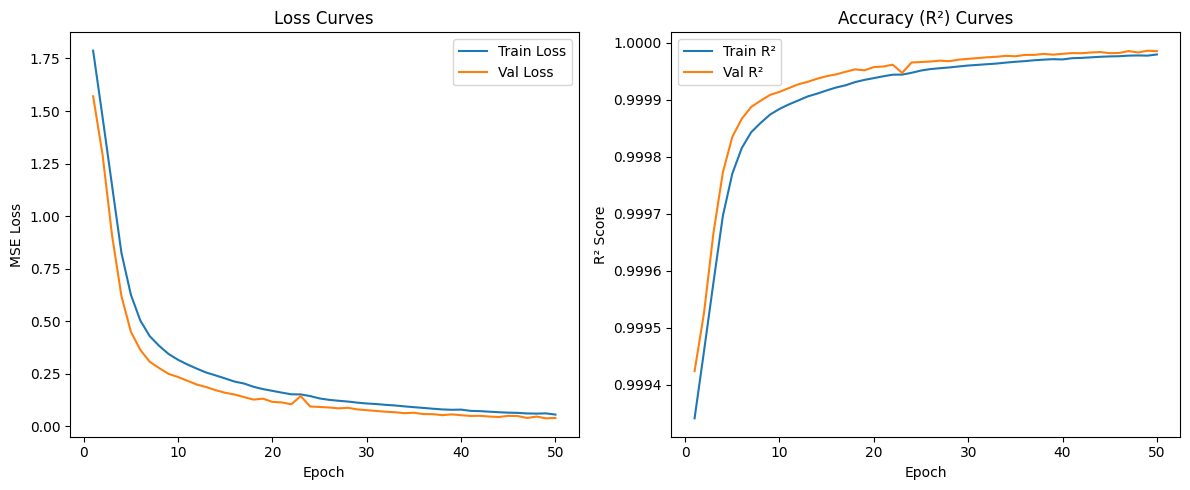

In [6]:
from model import TimeSeriesTransformer, PositionalEncoder  # if needed for reference; not used in TCN code here

# We'll assume the TCNModel definition is already in Cell 3.
# If not, please ensure you have defined TCNModel, TemporalConvNet, and TemporalBlock.

# Using the TCNModel defined earlier in Cell 3.
# If not defined, please refer to Cell 3 code provided earlier.
# Here, we continue from that definition.

# Loss, optimizer, and scheduler.
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters.
best_val_loss = float('inf')
epochs_no_improve = 0

def r2_score(y_true, y_pred):
    y_true = y_true.flatten().cpu().numpy()
    y_pred = y_pred.flatten().cpu().numpy()
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else 0.0

# History lists.
train_loss_hist = []
val_loss_hist = []
train_r2_hist = []
val_r2_hist = []

# Set epochs to 50.
epochs = 50

print("Starting training for 10 epochs...")
for epoch in range(epochs):
    model.train()
    epoch_losses = []
    all_train_preds = []
    all_train_targets = []
    
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # data: (batch, window_size, input_size)
        encoder_input = data.to(device).to(torch.float64)
        target_tensor = target.unsqueeze(1).to(device).to(torch.float64)
        
        # Forward pass.
        pred = model(encoder_input)
        loss = loss_func(pred, target_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        
        epoch_losses.append(loss.item())
        all_train_preds.append(pred.detach())
        all_train_targets.append(target_tensor.detach())
    
    avg_train_loss = np.mean(epoch_losses)
    train_loss_hist.append(avg_train_loss)
    train_preds = torch.cat(all_train_preds, dim=0)
    train_targets = torch.cat(all_train_targets, dim=0)
    train_r2 = r2_score(train_targets, train_preds)
    train_r2_hist.append(train_r2)
    
    # Validation phase.
    model.eval()
    val_losses = []
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Validation"):
            encoder_input = data.to(device).to(torch.float64)
            target_tensor = target.unsqueeze(1).to(device).to(torch.float64)
            pred = model(encoder_input)
            loss_val = loss_func(pred, target_tensor)
            val_losses.append(loss_val.item())
            all_val_preds.append(pred)
            all_val_targets.append(target_tensor)
    
    avg_val_loss = np.mean(val_losses)
    val_loss_hist.append(avg_val_loss)
    val_preds = torch.cat(all_val_preds, dim=0)
    val_targets = torch.cat(all_val_targets, dim=0)
    val_r2 = r2_score(val_targets, val_preds)
    val_r2_hist.append(val_r2)
    
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Train R²={train_r2:.4f}, Val Loss={avg_val_loss:.6f}, Val R²={val_r2:.4f}")
    
    # Scheduler step.
    scheduler.step(avg_val_loss)
    
    # Early stopping.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model, 'best_tcn_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 3:
            print("Early stopping triggered.")
            break

# Save training history.
np.save('tcn_train_loss_hist.npy', np.array(train_loss_hist))
np.save('tcn_val_loss_hist.npy', np.array(val_loss_hist))
np.save('tcn_train_r2_hist.npy', np.array(train_r2_hist))
np.save('tcn_val_r2_hist.npy', np.array(val_r2_hist))

# Plot loss and R² curves.
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, label="Train Loss")
plt.plot(range(1, len(val_loss_hist)+1), val_loss_hist, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_r2_hist)+1), train_r2_hist, label="Train R²")
plt.plot(range(1, len(val_r2_hist)+1), val_r2_hist, label="Val R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Accuracy (R²) Curves")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Cell 5: Testing  Single Timepoint Prediction
model.eval()

def mse_calc(x, x_hat):
    return nn.functional.mse_loss(x_hat, x)

test_mse_list = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Testing single timepoint"):
        # data shape: (batch, window_size, input_size)
        encoder_input = data.to(device).to(torch.float64)
        # target shape: (batch, input_size) -> unsqueeze to (batch, 1, input_size)
        target_tensor = target.unsqueeze(1).to(device).to(torch.float64)
        
        # For TCN, our model takes the entire sequence and predicts the next timepoint.
        pred = model(encoder_input)
        loss = mse_calc(target_tensor, pred)
        test_mse_list.append(loss.item())

test_mse_array = np.array(test_mse_list)
print("Test MSE shape:", test_mse_array.shape)
print("Average Test MSE:", test_mse_array.mean())

# Save results for future reference
np.save('tcn_test_results_single_timepoint.npy', test_mse_array)


Testing single timepoint: 100%|██████████| 28750/28750 [02:41<00:00, 178.09it/s]

Test MSE shape: (28750,)
Average Test MSE: 0.03966105797280159


In [8]:
# Cell 6: Testing  Full Series Prediction
def mse_calc(x, x_hat):
    return nn.functional.mse_loss(x_hat, x)

import glob
files = []
for sub in test_sub:
    sub_files = glob.glob(os.path.join(data_dir, sub, '*REST*_p.npy'))
    sub_files.sort()
    files += sub_files

all_session_pred = []
all_session_mse = []

print("Starting full series prediction...")
with torch.no_grad():
    for f in tqdm(files, desc="Predicting entire series"):
        f_data = np.load(f)  # shape: (1200, 379)
        # Start with the first max_window_size true timepoints.
        data_for_test = f_data[0:max_window_size, :].copy()
        ses_mse = []
        i = max_window_size
        while i < f_data.shape[0]:
            # Get the last window_size timepoints as input.
            window_data = data_for_test[i-window_size:i, :]
            window_tensor = torch.tensor(window_data).unsqueeze(0).to(device).to(torch.float64)
            # Predict the next timepoint.
            pred = model(window_tensor)
            pred = pred.squeeze().detach().cpu().numpy()
            
            # Compare prediction with the true timepoint.
            target = f_data[i, :]
            target_tensor = torch.tensor(target).unsqueeze(0).to(device).to(torch.float64)
            error = mse_calc(target_tensor.unsqueeze(1), 
                             torch.tensor(pred).unsqueeze(0).unsqueeze(0).to(device).to(torch.float64))
            ses_mse.append(error.item())
            
            # Append the predicted timepoint to our series.
            data_for_test = np.concatenate((data_for_test, pred.reshape(1, -1)), axis=0)
            i += 1
        
        all_session_pred.append(data_for_test)
        all_session_mse.append(ses_mse)

all_session_pred = np.array(all_session_pred)
all_session_mse = np.array(all_session_mse)
print("Predicted series shape:", all_session_pred.shape)
print("MSE series shape:", all_session_mse.shape)

np.save('tcn_predicted_fmri_series.npy', all_session_pred)
np.save('tcn_test_mse_entire_series.npy', all_session_mse)


Starting full series prediction...


Predicting entire series: 100%|██████████| 25/25 [01:17<00:00,  3.10s/it]


Predicted series shape: (25, 1200, 379)
MSE series shape: (25, 1150)


Predicted next brain state vector shape: (379,)


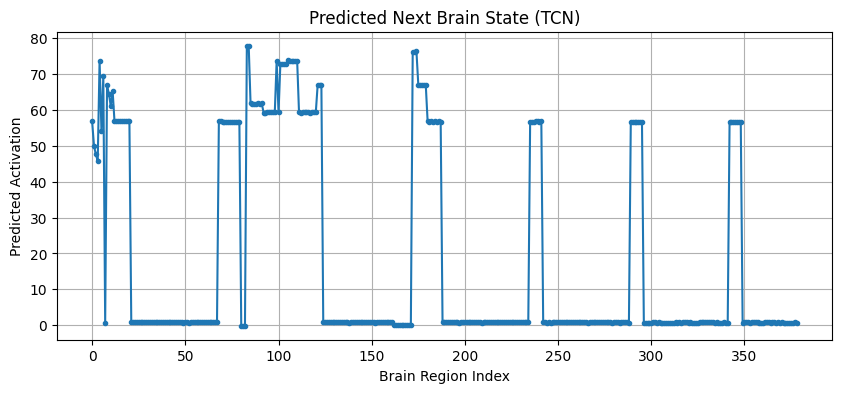

In [9]:
# Cell 7: Predicting the Next Brain State from a New Input Sequence
# For demonstration, use the predicted series of the first subject.
input_sequence = all_session_pred[0][-window_size:, :]  # shape: (window_size, 379)
input_sequence = np.expand_dims(input_sequence, axis=0)   # shape: (1, window_size, 379)

# Convert to torch tensor.
encoder_input = torch.tensor(input_sequence).to(device).to(torch.float64)

model.eval()
with torch.no_grad():
    next_state_pred = model(encoder_input)  # shape: (1, 1, 379)

next_state_pred = next_state_pred.squeeze().cpu().numpy()  # shape: (379,)
print("Predicted next brain state vector shape:", next_state_pred.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(next_state_pred, marker='o', linestyle='-', markersize=3)
plt.xlabel('Brain Region Index')
plt.ylabel('Predicted Activation')
plt.title('Predicted Next Brain State (TCN)')
plt.grid(True)
plt.show()


True time series shape: (1200, 379)
Predicted time series shape: (1200, 379)


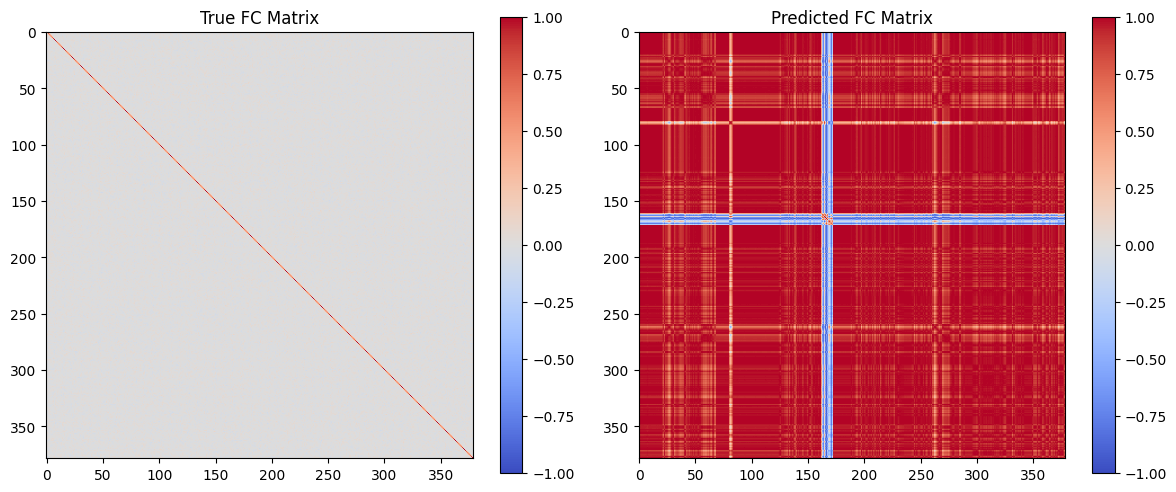

Mean Absolute Difference between FC matrices: 0.9203217735241637
Spatial Pearson correlation between FC matrices: r = -0.0005275914197740876 p-value = 0.8877104086858952


In [11]:
# Cell 8: Functional Connectivity Analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def compute_FC(time_series):
    """
    Compute the functional connectivity (FC) matrix using Pearson correlation.
    :param time_series: A numpy array of shape (timepoints, regions)
    :return: FC matrix of shape (regions, regions)
    """
    return np.corrcoef(time_series, rowvar=False)

# Load the true time series from one subject.
true_file = os.path.join(data_dir, train_sub[0], train_sub[0] + "_REST_p.npy")
true_ts = np.load(true_file)
print("True time series shape:", true_ts.shape)

# Use the predicted series from Cell 6 (first subject).
predicted_ts = all_session_pred[0]
print("Predicted time series shape:", predicted_ts.shape)

# Compute FC matrices.
FC_true = compute_FC(true_ts)
FC_pred = compute_FC(predicted_ts)

# Plot the FC matrices.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(FC_true, vmin=-1, vmax=1, cmap='coolwarm')
plt.title("True FC Matrix")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(FC_pred, vmin=-1, vmax=1, cmap='coolwarm')
plt.title("Predicted FC Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

# Compare the FC matrices using the upper triangle (excluding diagonal).
mask = np.triu(np.ones_like(FC_true, dtype=bool), k=1)
diff = np.abs(FC_true[mask] - FC_pred[mask])
mean_abs_diff = np.mean(diff)
print("Mean Absolute Difference between FC matrices:", mean_abs_diff)

# Compute spatial Pearson correlation.
r, p = pearsonr(FC_true[mask].flatten(), FC_pred[mask].flatten())
print("Spatial Pearson correlation between FC matrices: r =", r, "p-value =", p)


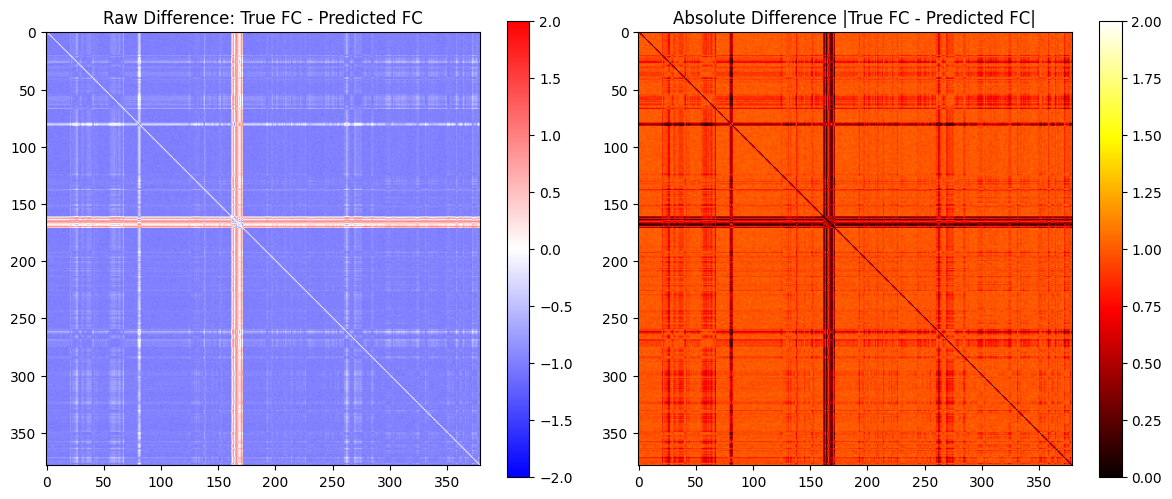

In [12]:
# Cell 9: Difference Matrix Visualization
import numpy as np
import matplotlib.pyplot as plt

# Compute difference or absolute difference
diff_matrix = FC_true - FC_pred
abs_diff_matrix = np.abs(diff_matrix)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(diff_matrix, vmin=-2, vmax=2, cmap='bwr')
plt.colorbar()
plt.title("Raw Difference: True FC - Predicted FC")

plt.subplot(1, 2, 2)
plt.imshow(abs_diff_matrix, vmin=0, vmax=2, cmap='hot')
plt.colorbar()
plt.title("Absolute Difference |True FC - Predicted FC|")

plt.tight_layout()
plt.show()


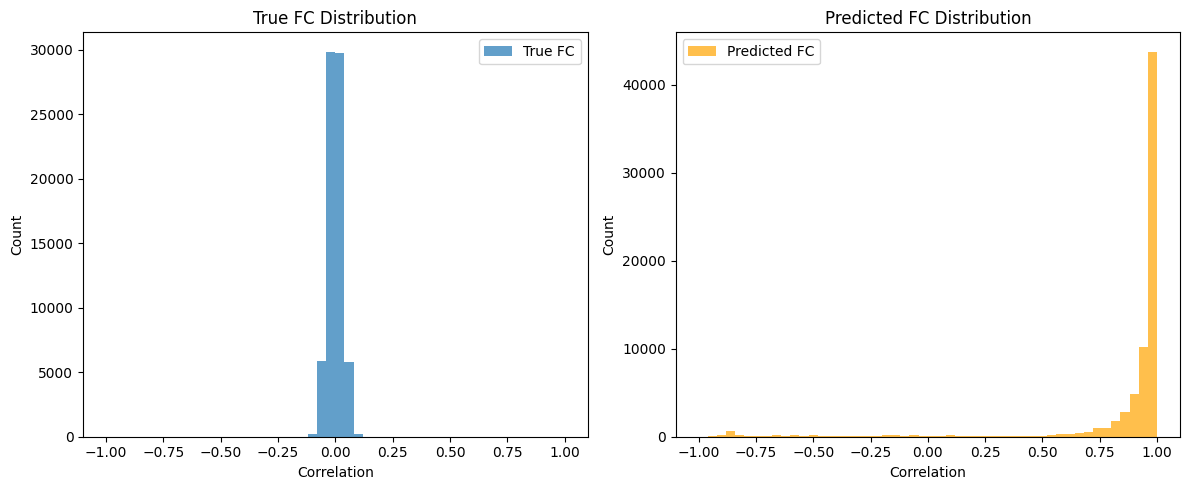

In [13]:
# Cell 10: Correlation Distribution
import numpy as np
import matplotlib.pyplot as plt

# Flatten upper triangles (excluding diagonal)
mask = np.triu(np.ones_like(FC_true, dtype=bool), k=1)
true_fc_vals = FC_true[mask]
pred_fc_vals = FC_pred[mask]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(true_fc_vals.flatten(), bins=50, range=(-1, 1), alpha=0.7, label='True FC')
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('True FC Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(pred_fc_vals.flatten(), bins=50, range=(-1, 1), alpha=0.7, color='orange', label='Predicted FC')
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Predicted FC Distribution')
plt.legend()

plt.tight_layout()
plt.show()


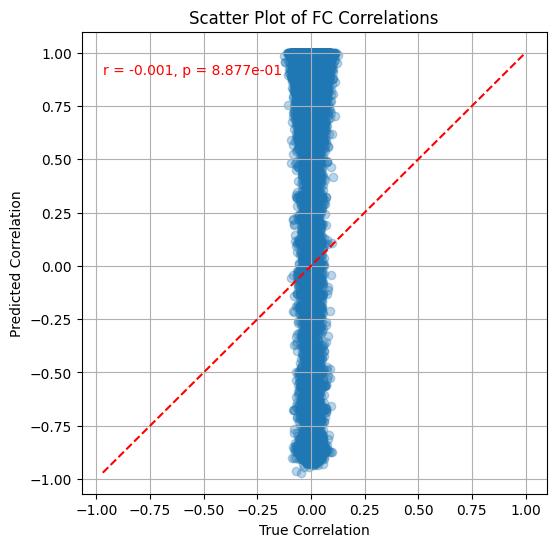

In [14]:
# Cell 11: Scatter Plot of True vs. Predicted Correlations
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

true_vals = true_fc_vals.flatten()
pred_vals = pred_fc_vals.flatten()

plt.figure(figsize=(6, 6))
plt.scatter(true_vals, pred_vals, alpha=0.3)
plt.xlabel('True Correlation')
plt.ylabel('Predicted Correlation')
plt.title('Scatter Plot of FC Correlations')

# Optionally, add a line of y=x
min_val = min(true_vals.min(), pred_vals.min())
max_val = max(true_vals.max(), pred_vals.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

# Compute correlation
r, p = pearsonr(true_vals, pred_vals)
plt.text(min_val, max_val*0.9, f'r = {r:.3f}, p = {p:.3e}', color='red')

plt.grid(True)
plt.show()


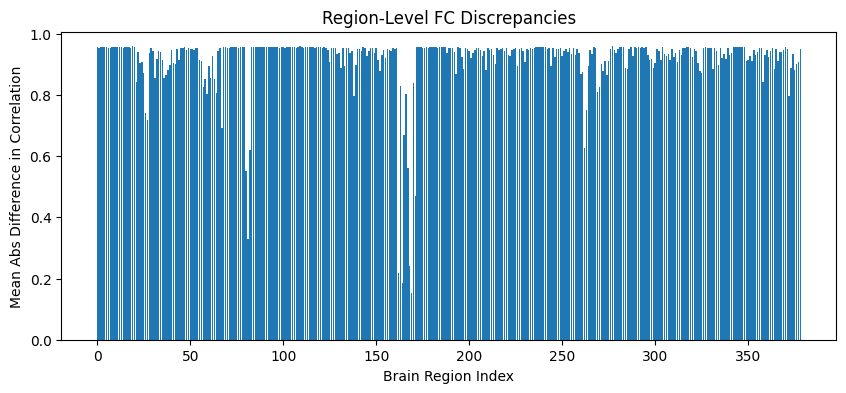

Top 5 regions with largest connectivity discrepancy:
Region 109: Mean Abs Diff = 0.9583
Region 277: Mean Abs Diff = 0.9580
Region 19: Mean Abs Diff = 0.9580
Region 173: Mean Abs Diff = 0.9579
Region 179: Mean Abs Diff = 0.9576


In [15]:
# Cell 12: Region-Level Differences
mean_abs_diff_per_region = np.mean(abs_diff_matrix, axis=1)  # average across columns

plt.figure(figsize=(10, 4))
plt.bar(range(len(mean_abs_diff_per_region)), mean_abs_diff_per_region)
plt.xlabel('Brain Region Index')
plt.ylabel('Mean Abs Difference in Correlation')
plt.title('Region-Level FC Discrepancies')
plt.show()

# Sort regions by discrepancy
sorted_indices = np.argsort(-mean_abs_diff_per_region)
print("Top 5 regions with largest connectivity discrepancy:")
for i in range(5):
    region_id = sorted_indices[i]
    print(f"Region {region_id}: Mean Abs Diff = {mean_abs_diff_per_region[region_id]:.4f}")
